<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
    Minimum Enclosing Ball
</h1>

Accompanying notebook for the lecture note on Machine Learning:

  * Christian Bauckhage and Tiansi Dong: "Minimum Enclosing Balls", B-IT, University of Bonn, February 2019 ([Download from ResearchGate](https://www.researchgate.net/publication/331152293_Lecture_Notes_on_Machine_Learning_Minimum_Enclosing_Balls))

  * Abstract of the paper: *The minimum enclosing ball problem is another example of a problem that can be cast as a constrained convex optimization problem. It thus provides us with another opportunity to work with the Karush-Kuhn-Tucker (KKT) conditions and to derive a Lagrangian dual which, as we shall see later, allows for a simple solution for the problem.*
  
<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from functools import partial

## Plotting utilities

In [2]:
blu = '#0059ff' # hsv(219., 1., 1. ); // blue 
ora = '#ffa500' # hsv( 39., 1., 1. ); // orange

alpha_now = 1.0
alpha_old = 0.2

def plot_points(axs, X):
    axs.plot(X[0,:], X[1,:], 'o', color='k', mew=0, ms=7, alpha=0.5)
    
def plot_circle(axs, c, r, alpha=alpha_now):
    axs.plot(c[0], c[1], 'o', color=blu, mew=0, ms=7, alpha=alpha)
    axs.add_patch(Circle(c, r, fc='none', ec=blu, alpha=alpha))
    
def plot_reference_point(axs, p, alpha=alpha_now):
    axs.plot(p[0], p[1], 'o', color=ora, mew=0, ms=7, alpha=alpha)

def stretch_range(a, b, s):
    c = (a + b) / 2
    d = (b - a) / 2 * s
    return c - d, c + d
    
def find_limits(X):
    xmin, xmax = stretch_range(X[0, :].min(), X[0, :].max(), 1.25)
    ymin, ymax = stretch_range(X[1, :].min(), X[1, :].max(), 1.25)
    return [xmin, xmax, ymin, ymax]

def init_plots(n, lims=None):
    f, [axs] = plt.subplots(1, n, figsize = (18, min(6, 18/n)), squeeze=False)
    for a in axs:
        if lims: a.set_xlim(lims[0], lims[1])
        if lims: a.set_ylim(lims[2], lims[3])
        a.set_aspect(aspect='equal', adjustable='box')
        a.set_axis_off()
    return axs[0] if len(axs) == 1 else axs

def done_plots():
    plt.show()
    plt.close()    

## Frank-Wolfe Optimization

In [3]:
def frank_wolfe_optimization(n, gradient_at, tmax=1000, show=lambda state, t, eta, grd, s, mu: None):
    
    I  = np.identity(n)
    mu = np.ones(n) / n

    for t in range(tmax):
        
        eta = 2. / (t + 2)
        
        grd = gradient_at(mu)
        s   = np.argmin(grd)
        
        mu += eta * (I[s] - mu)                                ; show('updated', t, eta, grd, s, mu)

    return mu

## Translation of the Minimal Enclosing Ball to Frank-Wolfe Optimization

In [4]:
def init_ingredients(X):
    XtX = X.T.dot(X)
    return XtX, np.diag(XtX)

def neg_lagrangian_dual_gradient(XtX, Z, w):
    return -Z + 2 * XtX.dot(w)

def distance(X, Z, c, r):
    D = np.maximum(np.sqrt(Z - 2 * c.T.dot(X) + c.T.dot(c)) - r, 0)
    return np.sqrt(D.dot(D.T))

def center(X, mu):
    return X.dot(mu)

def radius(XtX, Z, mu):
    return np.sqrt(Z.dot(mu) - mu.dot(XtX.dot(mu)))

## Visualization Utility

In [5]:
def show_updated_ball(n_cols, lims, X, XtX, Z, 
                      state, t, eta, grd, s, mu):
    
    global col, axs, prev_c, prev_r
    
    if t == 0: col = 0; prev_c = None; prev_r = None
    if col == 0: axs = init_plots(n_cols, lims)
    a = axs[col]
    
    c = center(X, mu)
    r = radius(XtX, Z, mu)
    d = distance(X, Z, c, r)
    
    a.set_title('{}) $\eta$={:.3}, s={}, d={:.3}'.format(t+1, eta, s, d))
    if prev_r: plot_circle(a, prev_c, prev_r, alpha=alpha_old)
    plot_points(a, X)
    plot_reference_point(a, X[:, s])
    plot_circle(a, c, r)
        
    prev_c, prev_r = c, r
    col += 1
    if col == n_cols: 
        done_plots(); col = 0    

## Examples

In [6]:
def generate_noisy_half_moon(n, r=1., noise=0.1):
    t = np.linspace(np.pi/4, np.pi + np.pi/4, n)
    X = np.vstack((r * np.cos(t) + noise * np.random.randn(n),
                   r * np.sin(t) + noise * np.random.randn(n)))
    return X

def generate_gaussian_blob(n, mu=np.zeros(2), S=np.identity(2)):
    x, y = rnd.multivariate_normal(mu, S, n).T
    return np.vstack((x, y))

def add_point(X, p):
    return np.append(X, p[:, np.newaxis], axis=1)

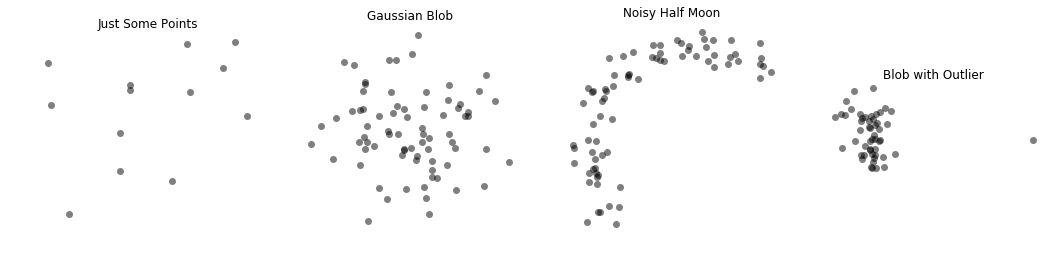

In [7]:
just_some_points  = generate_gaussian_blob(13)
gaussian_blob     = generate_gaussian_blob(75)
noisy_half_moon   = generate_noisy_half_moon(75)
blob_with_outlier = generate_gaussian_blob(50, S=np.array([[0.4, -0.05], [-0.05, 1.4]]))
blob_with_outlier = add_point(blob_with_outlier, np.array([9., 0.]))

axs = init_plots(4)
for a, points, title in zip(axs, [just_some_points, gaussian_blob, noisy_half_moon, blob_with_outlier],
                                 ['Just Some Points', 'Gaussian Blob', 'Noisy Half Moon', 'Blob with Outlier']):
    a.set_title(title)
    plot_points(a, points)
done_plots()

### Just Some Points

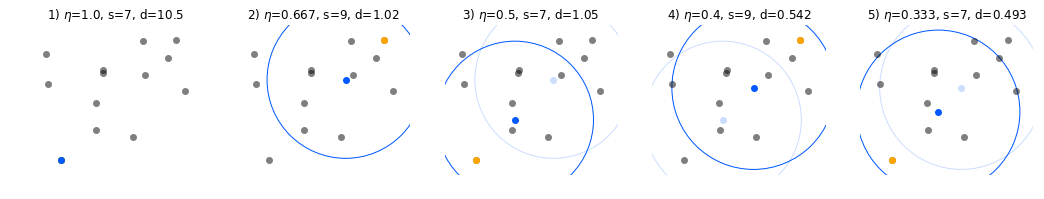

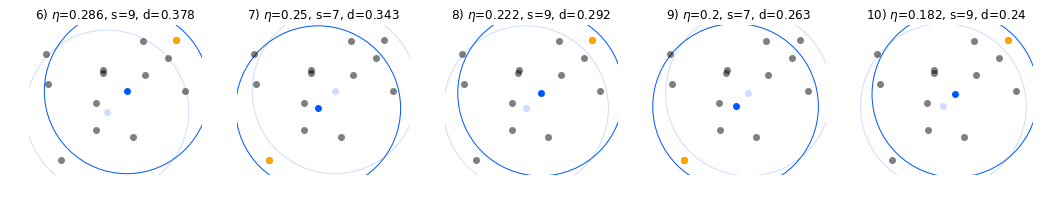

Center is  [ 0.298498   -0.59466139]  and radius is  2.2177174333101446


In [8]:
X      = just_some_points
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=10, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

### Gaussian Blob

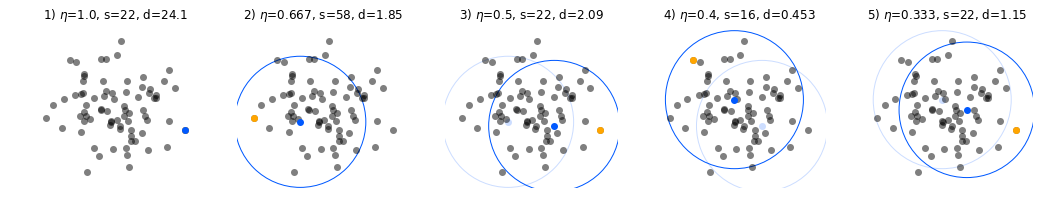

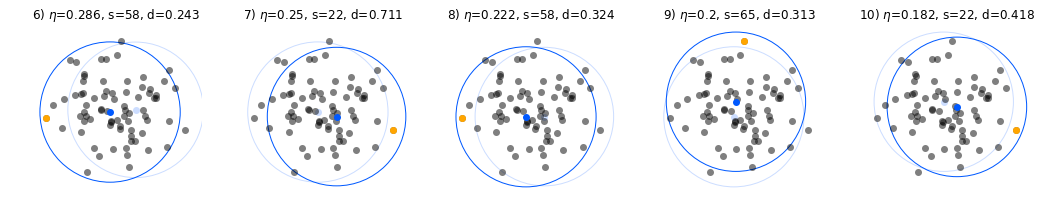

Center is  [ 0.26985159 -0.08185039]  and radius is  2.326979283473973


In [9]:
X      = gaussian_blob
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=10, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

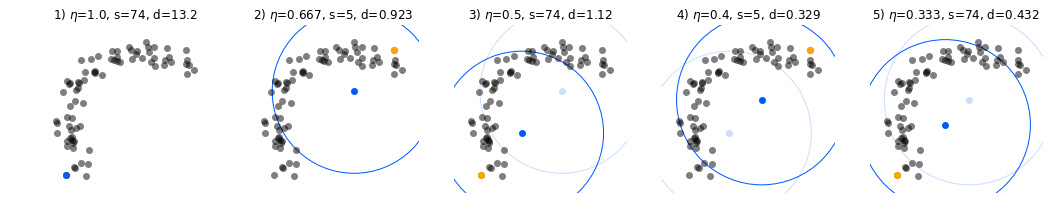

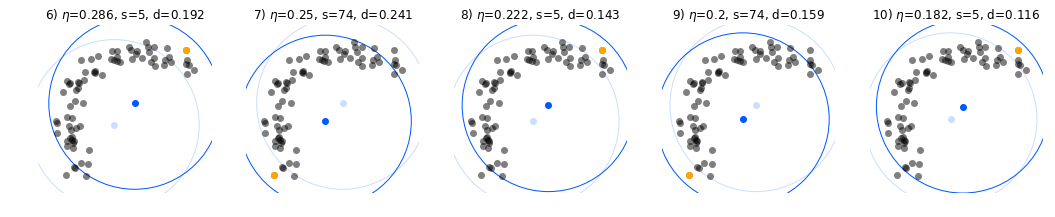

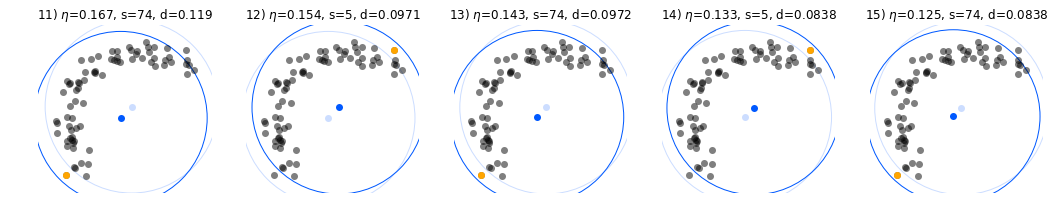

Center is  [-0.21668875  0.08712123]  and radius is  1.2133497758754377


In [10]:
X      = noisy_half_moon
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=15, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

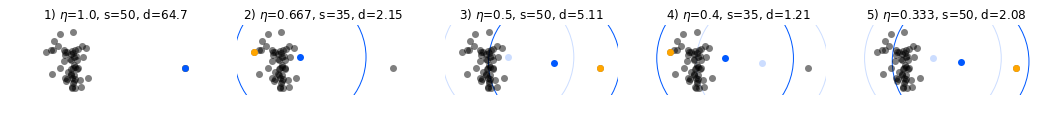

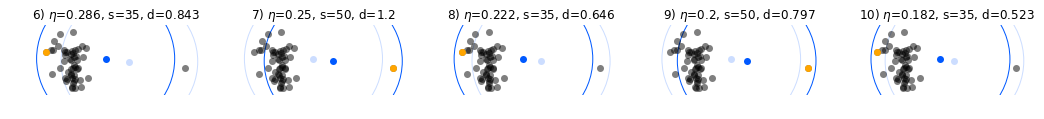

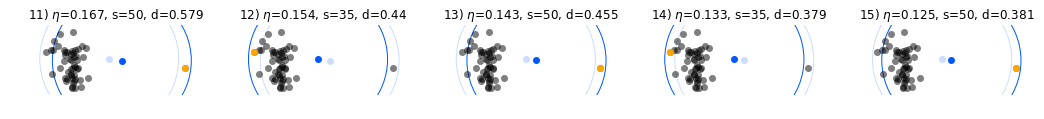

Center is  [3.89906022 0.60589395]  and radius is  5.4914681012396676


In [11]:
X      = blob_with_outlier
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=15, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

## There is Convergency

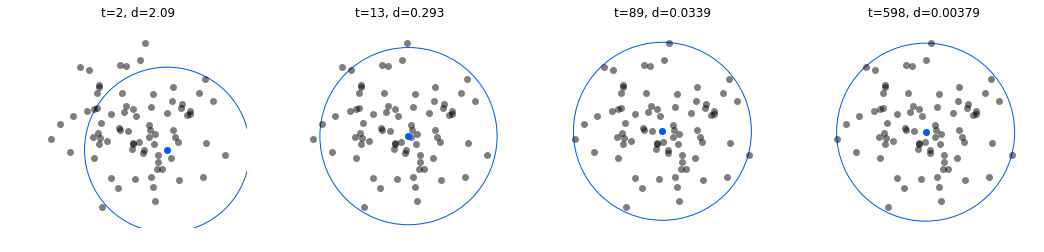

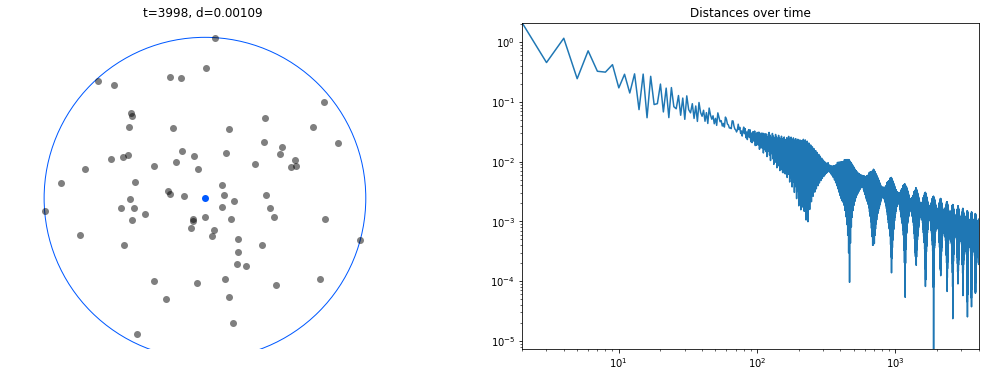

In [17]:
X      = gaussian_blob
XtX, Z = init_ingredients(X)
grad   = partial(neg_lagrangian_dual_gradient, XtX, Z)

tmax = 4000
centers   = np.zeros((tmax, 2))
radii     = np.zeros(tmax)
distances = np.zeros(tmax)

def remember_distances(state, t, eta, grd, s, mu):
    global centers, radii, distances
    c = center(X, mu)
    r = radius(XtX, Z, mu)
    d = distance(X, Z, c, r)
    centers[t], radii[t], distances[t] = c, r, d


mu = frank_wolfe_optimization(X.shape[1], grad, tmax=tmax, show=remember_distances)


ts = np.geomspace(2, tmax-1, 5, dtype=int)

axs = init_plots(len(ts[:-1]), find_limits(X))
for a, t in zip(axs, ts[:-1]):
    a.set_title('t={}, d={:.3}'.format(t, distances[t]))
    plot_points(a, X)
    plot_circle(a, centers[t], radii[t])
done_plots()

axs = init_plots(2)

axs[0].set_title('t={}, d={:.3}'.format(ts[-1], distances[-1]))
plot_points(axs[0], X)
plot_circle(axs[0], centers[-1], radii[-1])

axs[1].set_title('Distances over time')
axs[1].set_xlim(ts[0], tmax)
axs[1].set_ylim(distances.min(), distances[ts[0]:ts[0]+5].max())
axs[1].set_aspect(aspect='auto')
axs[1].set_axis_on()
axs[1].loglog(range(ts[0], tmax), distances[ts[0]:])

done_plots()

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage and D. Speicher<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>